# 다음에 볼 영화 
### Session-Based Recommendation
세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천

In [1]:
# 데이터 설명(README)를 읽어 봅니다. 
import os
f = open(os.getenv('HOME')+'/aiffel/yoochoose/data/dataset-README.txt', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

﻿SUMMARY




This dataset was constructed by YOOCHOOSE GmbH to support participants in the RecSys Challenge 2015.

See  http://recsys.yoochoose.net for details about the challenge.



The YOOCHOOSE dataset contain a collection of sessions from a retailer, where each session

is encapsulating the click events that the user performed in the session.

For some of the sessions, there are also buy events; means that the session ended

with the user bought something from the web shop. The data was collected during several

months in the year of 2014, reflecting the clicks and purchases performed by the users

of an on-line retailer in Europe.  To protect end users privacy, as well as the retailer,

all numbers have been modified. Do not try to reveal the identity of the retailer.



LICENSE


This dataset is licensed under the Creative Commons Attribution-NonCommercial-NoDerivatives 4.0

International License. To view a copy of this license, visit http://creativecommons.org/licenses/by-nc-nd

1. 유저에 대한 정보를 전혀 알 수 없습니다. (성별, 나이, 장소, 마지막 접속 날짜, 이전 구매 내역 등등 )
2. 아이템에 대한 정보도 전혀 알 수 없습니다. (실제로 어떤 물건인지, 사진이나 설명, 가격)
#### Sequential Recommendation
유저에 대한 정보를 알 수 있는 경우
#### Context-Aware
유저와 아이템의 추가 정보를 Sequential Recommendation 모델에 적용하는 분야
####  E-Commerce 데이터
- 비로그인 상태로 탐색하는 유저가 많다.
- 로그인 상태로 탐색한다고 할지라도 접속할 때마다 탐색하는 의도가 뚜렷하게 다르다.

## Data Preprocess
### Data Load

In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## 데이터 전처리

In [4]:
print(len(data))
display(data.head(10))

1000209


,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
36,1,1836,5,978300172
3,1,3408,4,978300275
7,1,2804,5,978300719
47,1,1207,4,978300719
0,1,1193,5,978300760


In [5]:
from datetime import datetime

print(datetime.fromtimestamp(978300019))
print(datetime.fromtimestamp(978300019).strftime("%Y/%m/%d, %H:%M:%S"))

2000-12-31 22:00:19
2000/12/31, 22:00:19


In [6]:
print(type(data)) # type 확인부터

data['Date'] = data['Time'].apply(lambda x:datetime.fromtimestamp(x)) 
display(data.head())

<class 'pandas.core.frame.DataFrame'>


,UserId,ItemId,Rating,Time,Date
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43


In [7]:
data.head(10)

,UserId,ItemId,Rating,Time,Date
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
36,1,1836,5,978300172,2000-12-31 22:02:52
3,1,3408,4,978300275,2000-12-31 22:04:35
7,1,2804,5,978300719,2000-12-31 22:11:59
47,1,1207,4,978300719,2000-12-31 22:11:59
0,1,1193,5,978300760,2000-12-31 22:12:40


In [8]:
data.tail(10)

,UserId,ItemId,Rating,Time,Date
1000169,6040,2725,4,997454180,2001-08-10 14:36:20
1000105,6040,1673,4,997454212,2001-08-10 14:36:52
1000118,6040,457,4,997454349,2001-08-10 14:39:09
1000119,6040,3671,4,997454367,2001-08-10 14:39:27
999923,6040,232,5,997454398,2001-08-10 14:39:58
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26
1000042,6040,1221,4,998315055,2001-08-20 13:44:15


In [9]:
del data['Time']
data.head()

,UserId,ItemId,Rating,Date
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


In [10]:
print(f'전체 갯수 : {len(data)}')
r1 = len(data[data['Rating']==1])
r2 = len(data[data['Rating']==2])
r3 = len(data[data['Rating']==3])
r4 = len(data[data['Rating']==4])
r5 = len(data[data['Rating']==5])

print(f'rating 1 갯수 : {r1}')
print(f'rating 2 갯수 : {r2}')
print(f'rating 3 갯수 : {r3}')
print(f'rating 4 갯수 : {r4}')
print(f'rating 5 갯수 : {r5}')

전체 갯수 : 1000209
rating 1 갯수 : 56174
rating 2 갯수 : 107557
rating 3 갯수 : 261197
rating 4 갯수 : 348971
rating 5 갯수 : 226310


In [11]:
r1_idx = data[data['Rating']==1].index
r2_idx = data[data['Rating']==2].index

data.drop(r1_idx, inplace=True)
data.drop(r2_idx, inplace=True)

print(f'전체 : {len(data)}')

전체 : 836478


In [12]:
print('User : ',len(data['UserId'].unique()))
print('Item : ',len(data['ItemId'].unique()))

User :  6039
Item :  3628


In [13]:
data['UserId'].nunique(), data['ItemId'].unique

(6039,
 <bound method Series.unique of 31         3186
 22         1270
 27         1721
 37         1022
 24         2340
            ... 
 1000019    2917
 999988     1921
 1000172    1784
 1000167     161
 1000042    1221
 Name: ItemId, Length: 836478, dtype: int32>)

#### Session Length

In [14]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       116
3        46
4        19
5       143
       ... 
6036    708
6037    189
6038     18
6039    119
6040    276
Length: 6039, dtype: int64

In [15]:
session_length.median(), session_length.mean()

(81.0, 138.51266766020865)

In [16]:
session_length.min(), session_length.max()

(1, 1968)

In [17]:
session_length.quantile(0.9)

328.0

In [18]:
long_session = session_length[session_length==30].index[0]
display(data[data['UserId']==long_session])
data[data['UserId']==long_session].shape

,UserId,ItemId,Rating,Date
11358,87,1197,3,2000-12-24 21:45:56
11359,87,1198,4,2000-12-24 21:48:28
11406,87,2028,4,2000-12-24 21:48:28
11357,87,1196,5,2000-12-24 21:49:01
11360,87,1277,4,2000-12-24 21:49:01
11379,87,2571,5,2000-12-24 21:49:01
11383,87,260,5,2000-12-24 21:49:01
11398,87,1201,4,2000-12-24 21:49:01
11409,87,1240,4,2000-12-24 21:49:01
11366,87,2194,5,2000-12-24 21:49:37


(30, 4)

In [19]:
print(len(data))
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

display(length_percent_cumsum_999)

836478


1       0.000166
7       0.000331
9       0.000994
10      0.001159
11      0.001987
          ...   
1029    0.998013
1034    0.998344
1054    0.998510
1106    0.998675
1116    0.998841
Length: 636, dtype: float64

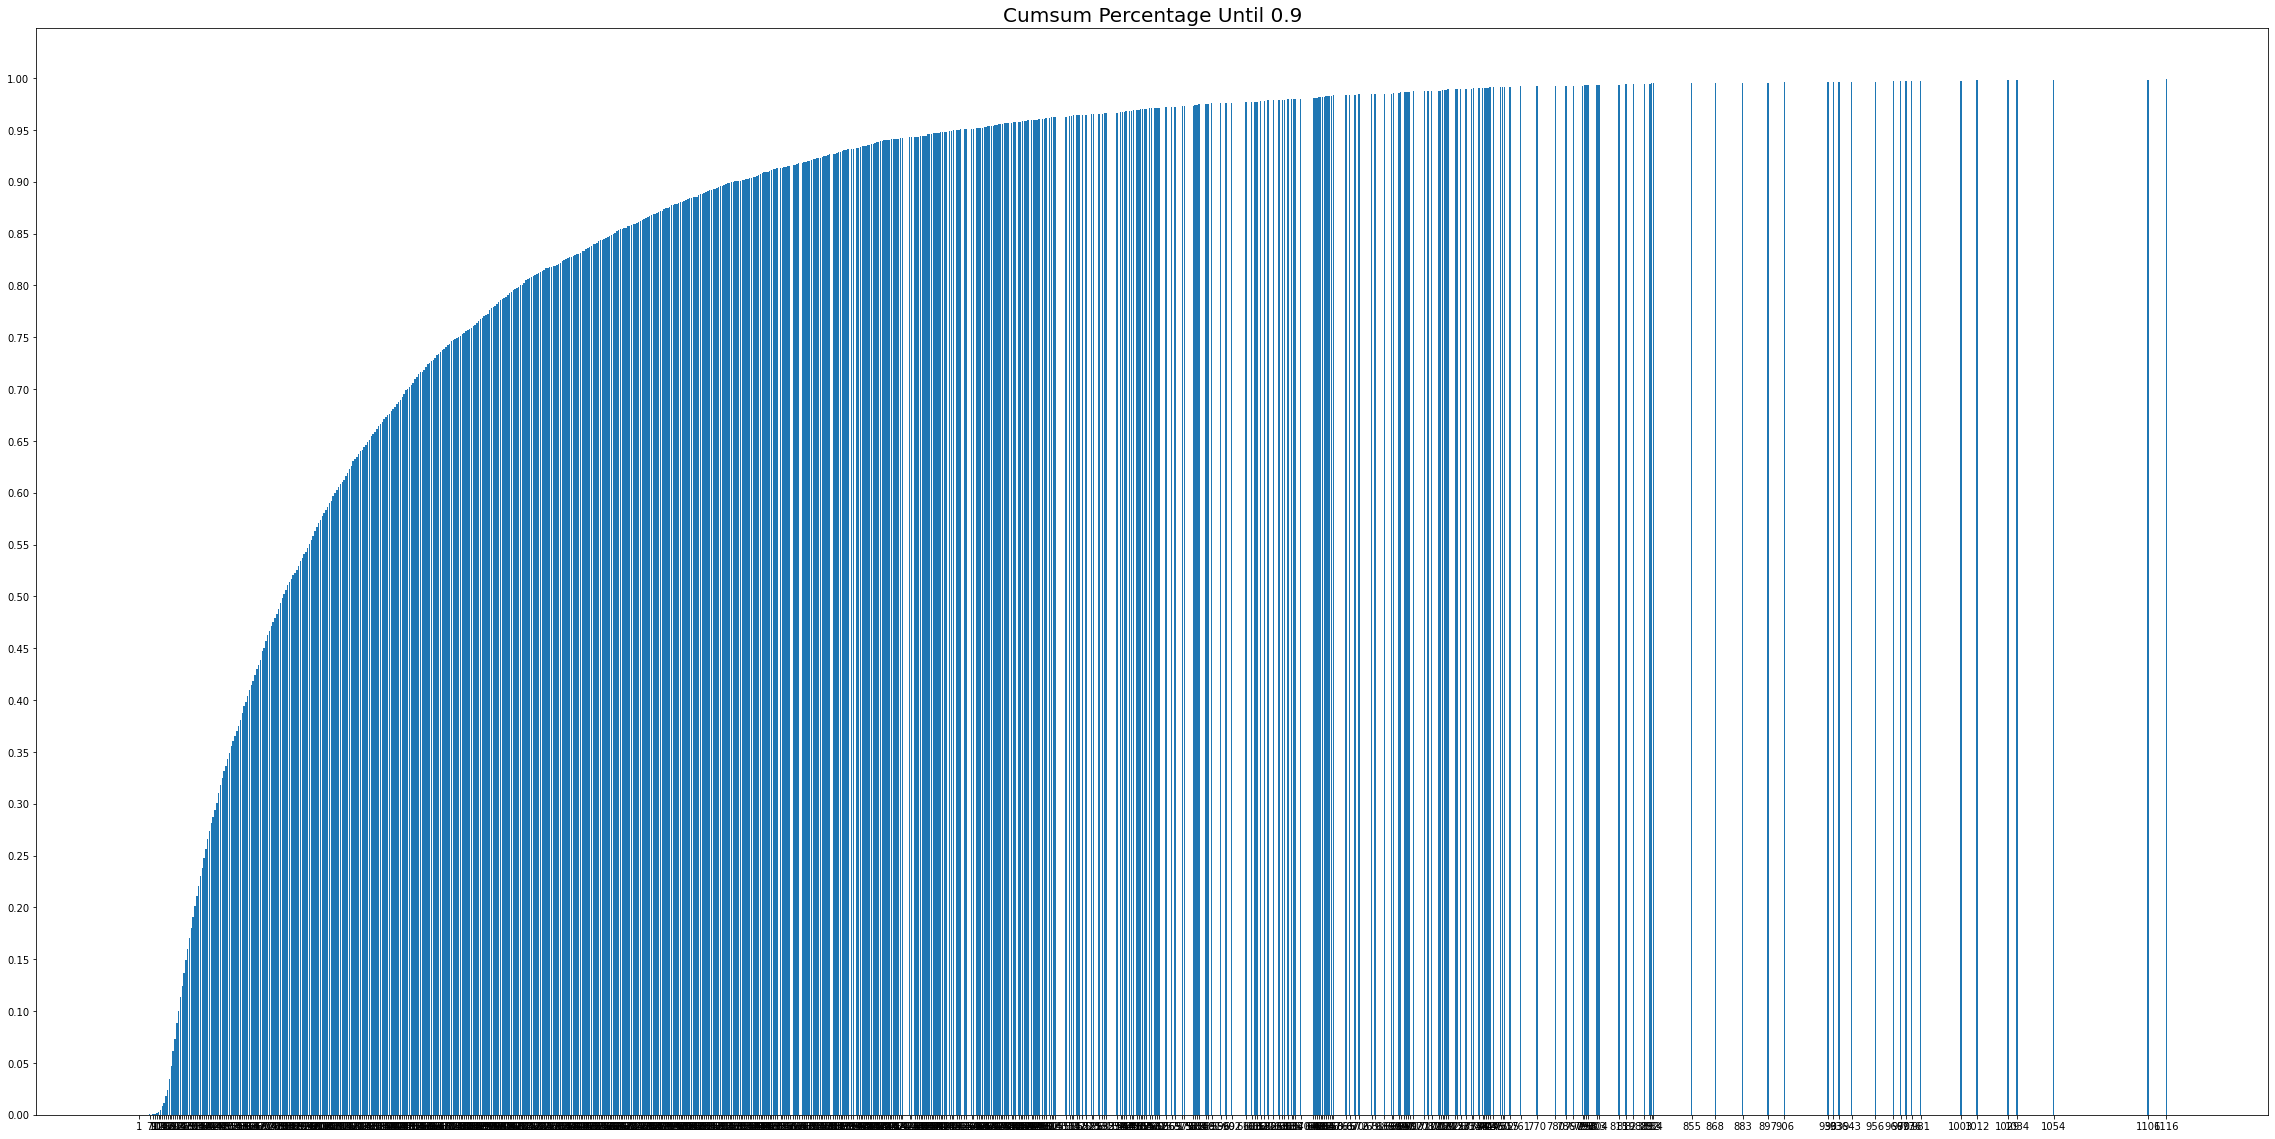

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 20))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999)
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.9', size=20)
plt.show()

#### Session Time

In [21]:
oldest, latest = data['Date'].min(), data['Date'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [22]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [23]:
len(data)

836478

#### Data Cleansing

In [24]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [25]:
data = cleanse_recursive(data, shortest=15, least_click=10) # 2,5
print(len(data))
display(data)

833834


,UserId,ItemId,Rating,Date
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


#### Train / Vali / Test split

In [26]:
data_backup = data.copy()

In [27]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Date'].max()
    print('final_time : ',final_time)
    session_last_time = data.groupby('UserId')['Date'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [28]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Date"].min()}\n'
          f'\t Last Time : {data["Date"].max()}\n')

In [29]:
session_length = data.groupby('UserId').size()

In [30]:
data['Date'].min(), data['Date'].max()

(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

In [31]:
data['Date'].max()-data['Date'].min()

Timedelta('1038 days 18:44:18')

In [32]:
len(data)

833834

In [33]:
print(session_length.quantile(0.8))
print(session_length.quantile(0.9))

213.0
330.0


In [34]:
tr, test = split_by_date(data, n_days=60)
tr, val = split_by_date(tr, n_days=90)

final_time :  2003-02-28 17:49:50
final_time :  2002-12-30 02:26:14


In [35]:
data = data.sort_values(by=['Date'])
tr, val, test = data[:-int(len(data)*(0.2))], data[-int(len(data)*(0.2)):-int(len(data)*(0.1))], data[-int(len(data)*(0.1)):]

In [36]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 667068
	 Sessions: 5347
	 Items: 3121
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2000-12-02 05:56:47

* valid Set Stats Info
	 Events: 83383
	 Sessions: 1113
	 Items: 3025
	 First Time : 2000-12-02 05:56:56
	 Last Time : 2000-12-29 14:54:21

* test Set Stats Info
	 Events: 83383
	 Sessions: 1208
	 Items: 3057
	 First Time : 2000-12-29 14:54:21
	 Last Time : 2003-02-28 17:49:50



In [37]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [38]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 미니 배치의 구성
#### SessionDataset

In [39]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [40]:
# Dataset 내용 확인
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Date,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999967,6040,3111,5,2000-04-25 23:07:36,5
999868,6040,573,4,2000-04-25 23:07:36,6
999877,6040,1419,3,2000-04-25 23:07:36,7
999920,6040,213,5,2000-04-25 23:07:36,8
999980,6040,3505,4,2000-04-25 23:07:36,9


In [41]:
tr_dataset.click_offsets

array([     0,    171,    279, ..., 666697, 666816, 667068], dtype=int32)

In [42]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5344, 5345, 5346])

#### SessionDataLoader

In [43]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [44]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Date,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
999873,6040,593,5,2000-04-25 23:05:54,1
1000153,6040,2384,4,2000-04-25 23:05:54,2
1000007,6040,1961,4,2000-04-25 23:06:17,3
1000192,6040,2019,5,2000-04-25 23:06:17,4
999967,6040,3111,5,2000-04-25 23:07:36,5
999868,6040,573,4,2000-04-25 23:07:36,6
999877,6040,1419,3,2000-04-25 23:07:36,7
999920,6040,213,5,2000-04-25 23:07:36,8
999980,6040,3505,4,2000-04-25 23:07:36,9


In [45]:
iter_ex = iter(tr_data_loader)

In [46]:
inputs, labels, mask =  next(iter_ex) # 제네레이터 다음 것들 받을 때
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0 166 245 308]
Label Item Idx are :       [  1  96 246 112]
Previous Masked Input Idx are []


## 모델 구성
### Evaluation Metric

In [47]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [49]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [50]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [51]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 1, 3121)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      475950    
_________________________________________________________________
dropout (Dropout)            (32, 50)                  0         
_________________________________________________________________
dense (Dense)                (32, 3121)                159171    
Total params: 635,121
Trainable params: 635,121
Non-trainable params: 0
_________________________________________________________________


## 모델 train, test

In [52]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [53]:
train_model(model, args)

Evaluation:  98%|█████████▊| 2507/2570 [08:16<00:12,  5.05it/s]


	 - Recall@20 epoch 1: 0.171270
	 - MRR@20    epoch 1: 0.040185



Evaluation:  98%|█████████▊| 2507/2570 [08:06<00:12,  5.16it/s]


	 - Recall@20 epoch 2: 0.204016
	 - MRR@20    epoch 2: 0.047731



Evaluation:  98%|█████████▊| 2507/2570 [08:06<00:12,  5.15it/s]

	 - Recall@20 epoch 3: 0.212493
	 - MRR@20    epoch 3: 0.051380



In [54]:
# 성능 검증
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  97%|█████████▋| 2497/2567 [08:13<00:13,  5.06it/s]

	 - Recall@20: 0.168978
	 - MRR@20: 0.040006



In [55]:
# drop rate 변경 : 0.1 -> 0.5
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.5, lr=0.0005, epochs=3, k=20)

In [56]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 1, 3121)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      475950    
_________________________________________________________________
dropout_1 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (32, 3121)                159171    
Total params: 635,121
Trainable params: 635,121
Non-trainable params: 0
_________________________________________________________________


In [57]:
train_model(model, args)

Evaluation:  98%|█████████▊| 2507/2570 [08:26<00:12,  4.95it/s]


	 - Recall@20 epoch 1: 0.099771
	 - MRR@20    epoch 1: 0.022942



Evaluation:  98%|█████████▊| 2507/2570 [08:24<00:12,  4.97it/s]


	 - Recall@20 epoch 2: 0.162009
	 - MRR@20    epoch 2: 0.037617



Evaluation:  98%|█████████▊| 2507/2570 [08:15<00:12,  5.06it/s]

	 - Recall@20 epoch 3: 0.184521
	 - MRR@20    epoch 3: 0.043051



In [58]:
test_model(model, args, test)

Evaluation:  97%|█████████▋| 2497/2567 [08:20<00:14,  4.99it/s]

	 - Recall@20: 0.145137
	 - MRR@20: 0.032953



In [59]:
# learning rate 변경 : 0.001 -> 0.0005
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.0005, epochs=3, k=20)

In [60]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(32, 1, 3121)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      475950    
_________________________________________________________________
dropout_2 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (32, 3121)                159171    
Total params: 635,121
Trainable params: 635,121
Non-trainable params: 0
_________________________________________________________________


In [61]:
train_model(model, args)

Evaluation:  98%|█████████▊| 2507/2570 [08:21<00:12,  5.00it/s]


	 - Recall@20 epoch 1: 0.119877
	 - MRR@20    epoch 1: 0.027179



Evaluation:  98%|█████████▊| 2507/2570 [08:17<00:12,  5.04it/s]


	 - Recall@20 epoch 2: 0.178313
	 - MRR@20    epoch 2: 0.041234



Evaluation:  98%|█████████▊| 2507/2570 [08:08<00:12,  5.14it/s]

	 - Recall@20 epoch 3: 0.200663
	 - MRR@20    epoch 3: 0.046798



In [62]:
test_model(model, args, test)

Evaluation:  97%|█████████▋| 2497/2567 [08:17<00:13,  5.01it/s]

	 - Recall@20: 0.159541
	 - MRR@20: 0.036346



## 회고
#### Session-Based Recommendation
세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천
#### Sequential Recommendation
유저에 대한 정보를 알 수 있는 경우
#### Context-Aware
유저와 아이템의 추가 정보를 Sequential Recommendation 모델에 적용하는 분야
####  E-Commerce 데이터
- 비로그인 상태로 탐색하는 유저가 많다.
- 로그인 상태로 탐색한다고 할지라도 접속할 때마다 탐색하는 의도가 뚜렷하게 다르다.
#### Evaluation Metric
- 모델성능에 대한 지표_precision/recall
- recall의 개념을 확장한 recall@k
- precision의 개념을 확장한 Mean Average Precision@k
- 정답 아이템이 나온 순번의 역수값_MRR

학습 진행 속도가 너무 느려서 epoch을 작게 잡고 진행하여서 loss값이 안정적으로 감소하거나 Recall, MRR이 인상적으로 개선되는 것을 확인하지 못하였다. 기다리는 것이 제일 힘들다.